<a href="https://colab.research.google.com/github/ntngann/UEL-RFM-Model/blob/EDA/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
import plotly.express as px
from scipy.stats import skew
import plotly.express as px
from scipy.stats import skew
from astropy.visualization import hist
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/Shareddrives/Fundamentals of DA/FINAL/Source-code/Dataset/online_retail.txt')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,SalesOrderID,OrderDate,Status,CustomerID,OrderQty,UnitPrice,UnitPriceDiscount,LineTotal
0,43659,2011-05-31 00:00:00,5,29825,1,2024.994,0.0,2024.994
1,43659,2011-05-31 00:00:00,5,29825,3,2024.994,0.0,6074.982
2,43659,2011-05-31 00:00:00,5,29825,1,2024.994,0.0,2024.994
3,43659,2011-05-31 00:00:00,5,29825,1,2039.994,0.0,2039.994
4,43659,2011-05-31 00:00:00,5,29825,1,2039.994,0.0,2039.994


#EDA

In [ ]:
df.describe()

,SalesOrderID,Status,CustomerID,OrderQty,UnitPrice,UnitPriceDiscount,LineTotal
count,121317.000000,121317.0,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000
mean,57827.363782,5.0,24345.630505,2.266080,465.093496,0.002826,905.449207
std,9009.147902,0.0,6689.110387,2.491323,751.885081,0.024811,1693.417389
min,43659.000000,5.0,11000.000000,1.000000,1.328200,0.000000,1.374000
25%,49884.000000,5.0,18177.000000,1.000000,21.490000,0.000000,24.990000
50%,57029.000000,5.0,29485.000000,1.000000,49.990000,0.000000,134.982000
75%,65490.000000,5.0,29795.000000,3.000000,602.346000,0.000000,1120.490000
max,75123.000000,5.0,30118.000000,44.000000,3578.270000,0.400000,27893.619000


In [ ]:
num_features=['OrderQty','UnitPrice','UnitPriceDiscount','LineTotal']

## Histogram

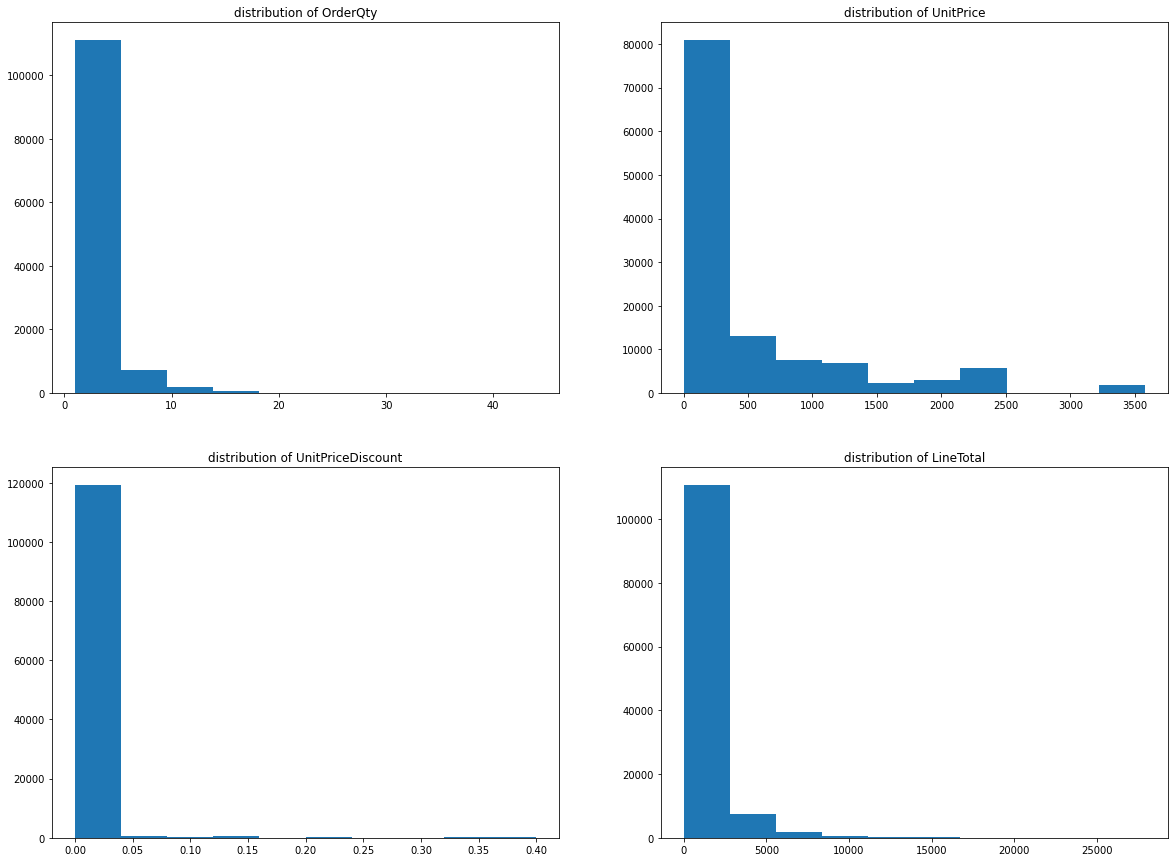

In [ ]:
plt.rcParams["figure.figsize"] = (20,15)

fig, axs = plt.subplots(2, 2)
cnt = 0
for i in range(2):
    for j in range(2):
        axs[i,j].hist(df[num_features[cnt]])
        axs[i,j].set_title('distribution of '+ num_features[cnt])
        cnt +=1

In [ ]:
df['Amount'] = df['OrderQty'] * df['UnitPrice']

In [ ]:
print("Columns with data types:\n{}".format(df.dtypes))
print("Missing values: \n{}".format(df.isnull().sum()))

Columns with data types:
SalesOrderID           int64
OrderDate             object
Status                 int64
CustomerID             int64
OrderQty               int64
UnitPrice            float64
UnitPriceDiscount    float64
LineTotal            float64
Amount               float64
dtype: object
Missing values: 
SalesOrderID         0
OrderDate            0
Status               0
CustomerID           0
OrderQty             0
UnitPrice            0
UnitPriceDiscount    0
LineTotal            0
Amount               0
dtype: int64


##Bar chart

In [ ]:
df['OrderDate'] = pd.DatetimeIndex(df['OrderDate'])
df['Year'] = pd.DatetimeIndex(df['OrderDate']).year
df['Month'] = pd.DatetimeIndex(df['OrderDate']).month

**Getting knownledge about total of sales order per month**



The active duration began from 06/2013 to 05/2014

**Calculate the number of sales order and total revenue per month**

In [ ]:
no_of_sales_order=df.groupby(['Month']).SalesOrderID.count()
total_revenue=df.groupby(['Month']).Amount.sum()
print(no_of_sales_order)
print(total_revenue)

Month
1     2877
2     2300
3     3144
4     2812
5     3175
6     2189
7     2356
8     2324
9     2300
10    2616
11    2716
12    2656
Name: SalesOrderID, dtype: int64
Month
1     1.035122e+07
2     5.133348e+06
3     1.362926e+07
4     6.101872e+06
5     1.228506e+07
6     9.796689e+06
7     1.047573e+07
8     8.019099e+06
9     8.497628e+06
10    1.193983e+07
11    5.925381e+06
12    8.218773e+06
Name: Amount, dtype: float64


In [ ]:
px.bar(df[['OrderDate','Amount']].set_index('OrderDate').resample('M').sum().reset_index(),
       x='OrderDate', y='Amount', title = 'Total revenue per month')

In [ ]:
px.bar(df[['OrderDate','SalesOrderID']].set_index('OrderDate').resample('M').count().reset_index(),
       x='OrderDate', y='SalesOrderID', title = 'Number of sales order per month')

##Scatter
* To view the relationship and distribution
* From overall trend, this is a positive relationship. As the x-values increase, the y-values increase



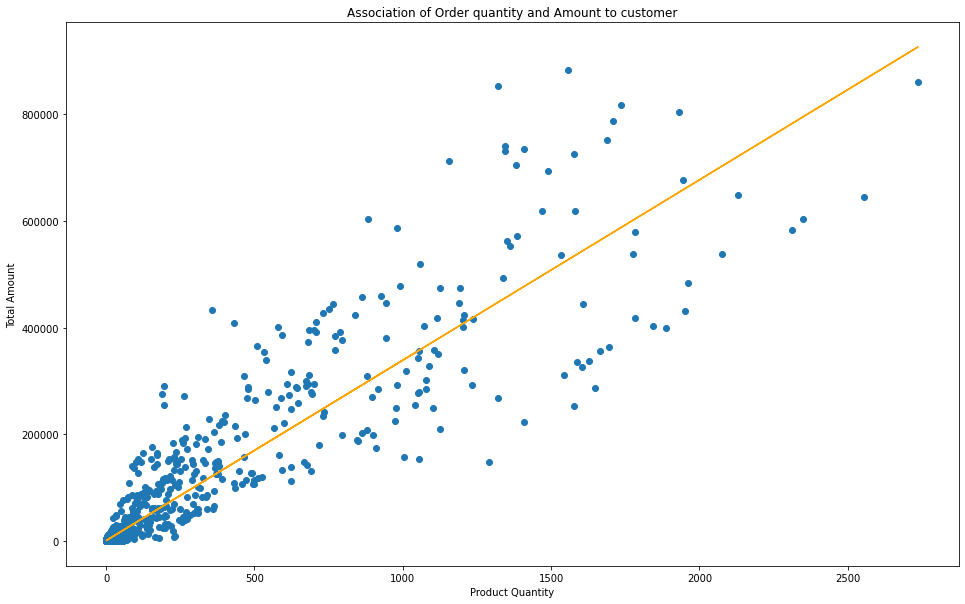

In [ ]:
df_scatter = df
df_scatter['m_y'] = df['OrderDate'].apply(lambda x: str(x.year) + '-' + str(x.month))
df_scatter = df_scatter.groupby(['CustomerID']).agg({'OrderQty': lambda x: x.sum(),
                                      'Amount': lambda x:x.sum()
                                      })
plt.figure(figsize=(16, 10))
x = df_scatter['OrderQty']
y = df_scatter['Amount']
plt.scatter(x, y)
plt.xlabel("Product Quantity")
plt.ylabel("Total Amount")
plt.title("Association of Order quantity and Amount to customer")

#draw trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), "orange")


# Calculate RFM value

In [ ]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'] )
##Find the last order date
snapshot_date=df['OrderDate'].max()+ dt.timedelta(days=1) 
print('The last order is placed on {}'.format(snapshot_date))

The last order is placed on 2014-07-01 00:00:00


In [ ]:
# #Calculate the number of days since customer's last order
# df['no_of_days'] = snapshot_date - df['OrderDate']
# df['no_of_days'] = df['no_of_days'].astype('timedelta64[D]')

In [ ]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'] )

period = (df['OrderDate'].max() - df['OrderDate'].min()).days

In [ ]:
df = df.groupby(['SalesOrderID', 'OrderDate', 'CustomerID']).agg({'LineTotal': lambda x: x.sum()}).reset_index()
df.head()

,SalesOrderID,OrderDate,CustomerID,LineTotal
0,43659,2011-05-31,29825,20565.6206
1,43660,2011-05-31,29672,1294.2529
2,43661,2011-05-31,29734,32726.4786
3,43662,2011-05-31,29994,28832.5289
4,43663,2011-05-31,29565,419.4589


In [ ]:
df['DaysSinceOrder'] = df['OrderDate'].apply(lambda x: (snapshot_date - x).days)

In [ ]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'OrderDate': lambda x: len([d for d in x if d >= snapshot_date - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = df.groupby('CustomerID').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'OrderDate': 'Frequency'}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency
0,11000,271,3
1,11001,50,3
2,11002,340,3
3,11003,264,2
4,11004,273,3


In [ ]:
df.head()

,SalesOrderID,OrderDate,CustomerID,LineTotal,DaysSinceOrder
0,43659,2011-05-31,29825,20565.6206,1127
1,43660,2011-05-31,29672,1294.2529,1127
2,43661,2011-05-31,29734,32726.4786,1127
3,43662,2011-05-31,29994,28832.5289,1127
4,43663,2011-05-31,29565,419.4589,1127


In [ ]:
print(df.OrderDate.max())
print(df.OrderDate.min())
print(period)

2014-06-30 00:00:00
2011-05-31 00:00:00
1126


In [ ]:
snapshot_date - timedelta(days=period)

Timestamp('2011-06-01 00:00:00')

In [ ]:
df[(df['CustomerID']==29825) & (df['OrderDate'] >= snapshot_date - timedelta(days=period))]['LineTotal'].sum()

402140.981651

In [ ]:
rfm['Monetary'] = rfm['CustomerID'].apply(lambda x: df[(df['CustomerID'] == x) & \
                                                           (df['OrderDate'] >= snapshot_date - timedelta(days=period))]\
                                                           ['Amount'].sum())
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,11000,271,3,8248.99
1,11001,50,3,6383.88
2,11002,340,3,8114.04
3,11003,264,2,4739.30
4,11004,273,3,8196.01


In [ ]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,19119.000000,19119.000000,19119.000000,19119.000000
mean,20559.000000,191.267483,1.643496,5746.643831
std,5519.324234,150.423605,1.447915,38784.160223
min,11000.000000,1.000000,0.000000,0.000000
25%,15779.500000,86.000000,1.000000,54.975000
50%,20559.000000,166.000000,1.000000,548.980000
75%,25338.500000,264.000000,2.000000,2820.412850
max,30118.000000,1127.000000,28.000000,882276.496600


##Histogram

(array([6631., 5882., 4645., 1386.,  135.,   59.,   69.,   87.,  144.,
          81.]),
 array([1.0000e+00, 1.1360e+02, 2.2620e+02, 3.3880e+02, 4.5140e+02,
        5.6400e+02, 6.7660e+02, 7.8920e+02, 9.0180e+02, 1.0144e+03,
        1.1270e+03]),
 <a list of 10 Patch objects>)

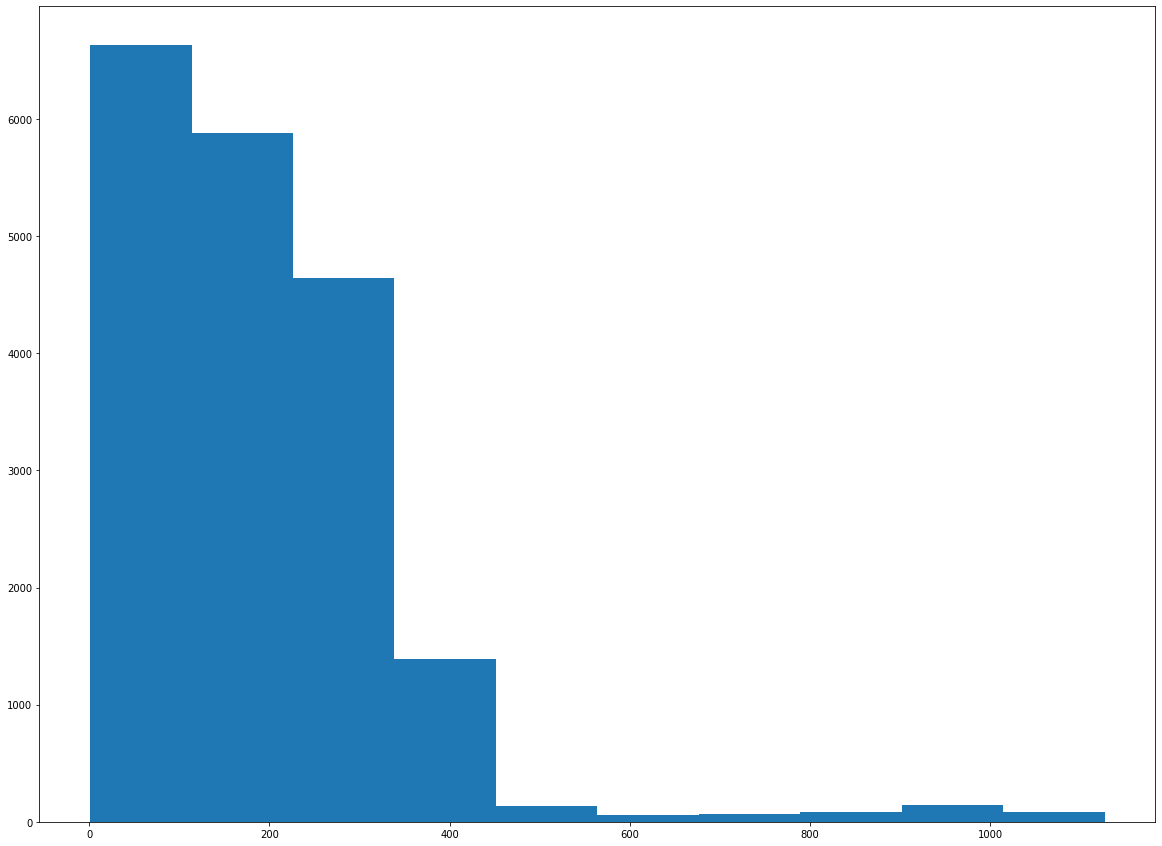

In [ ]:
rec = rfm['Recency']
fre = rfm['Frequency']
mon = rfm['Monetary']
hist(rec, bins=10)

**Histogram of frequency**

Text(0.5, 1.0, 'Histogram of frequency')

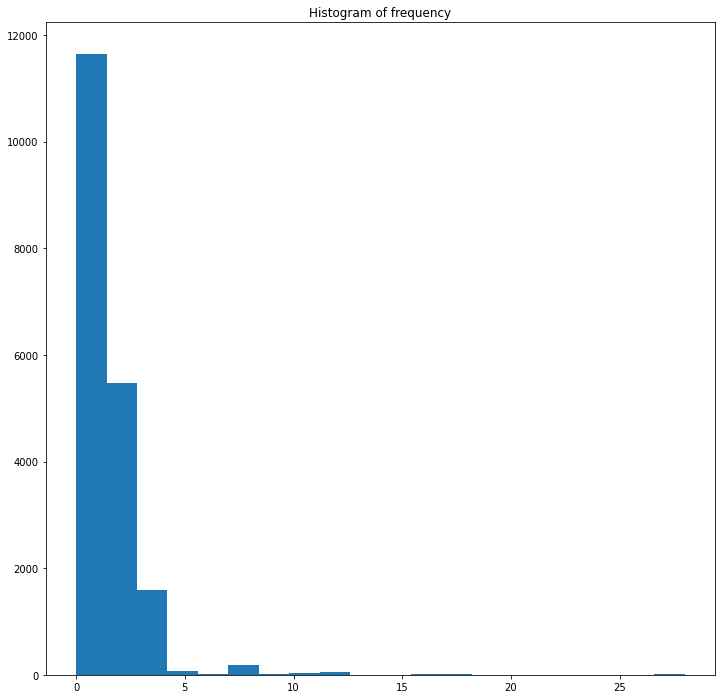

In [ ]:
plt.figure(figsize=(12, 12))
plt.hist(fre,bins=20)
plt.title("Histogram of frequency")

Text(0.5, 1.0, 'Histogram of frequency with range > 50')

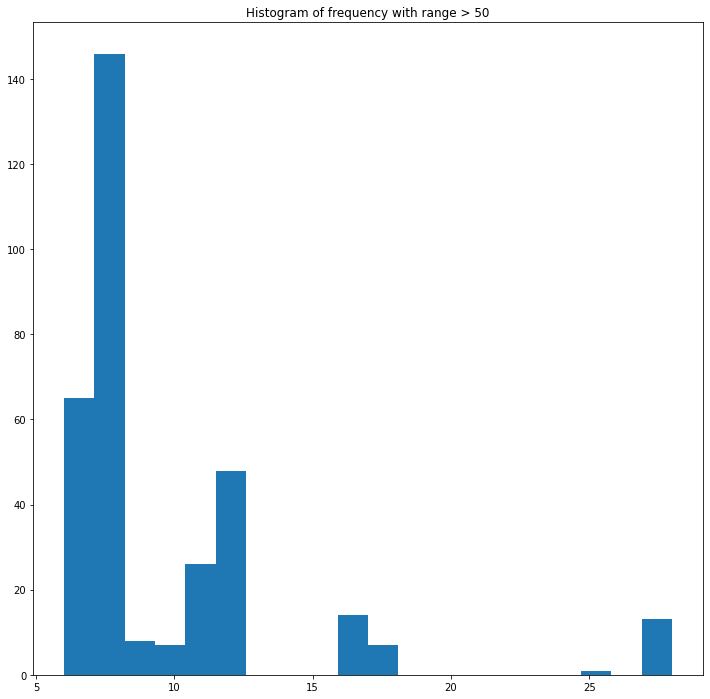

In [ ]:
plt.figure(figsize=(12, 12))
plt.hist(fre[fre > 5],bins=20)
plt.title("Histogram of frequency with range > 50")

**Histogram of monetary**

Text(0.5, 1.0, 'Histogram of monetary')

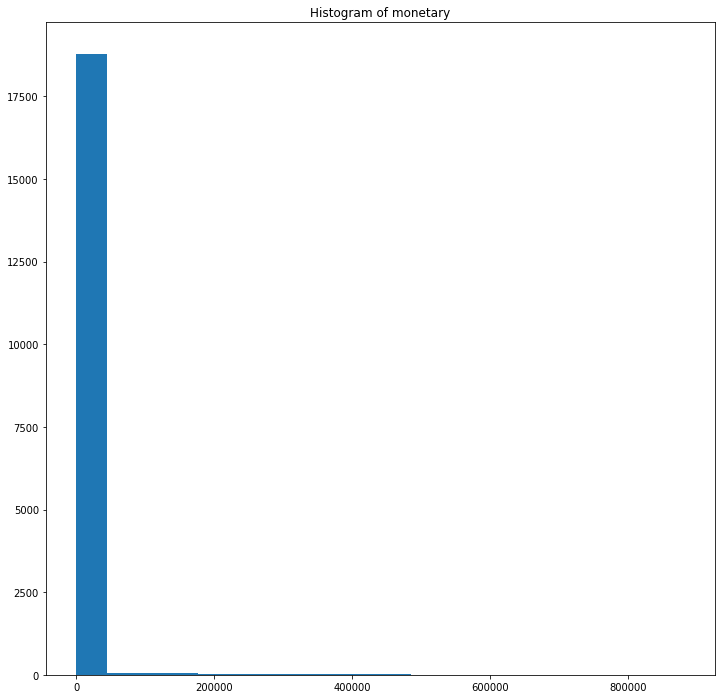

In [ ]:
plt.figure(figsize=(12, 12))
plt.hist(mon,bins=20)
plt.title("Histogram of monetary")

Text(0.5, 1.0, 'Histogram of monetary with range > 20000')

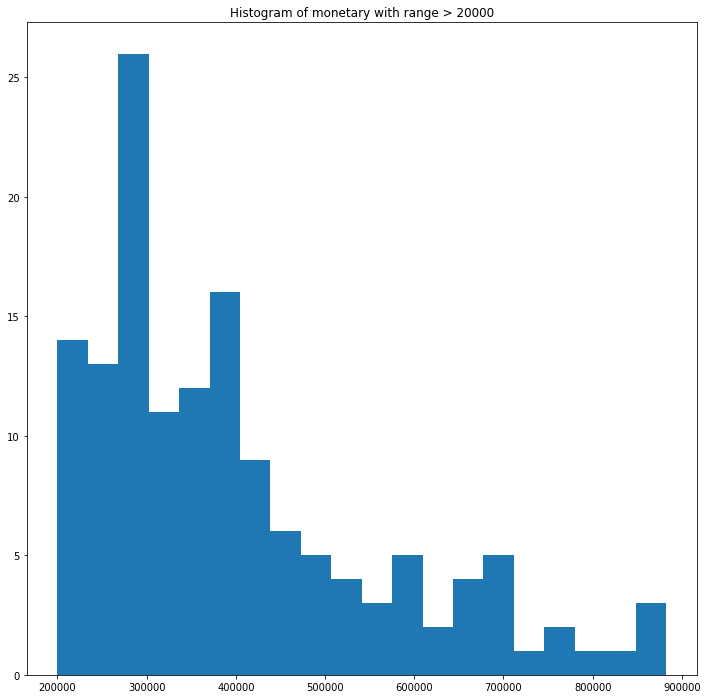

In [ ]:
plt.figure(figsize=(12, 12))
plt.hist(mon[200000 < mon],bins=20)
plt.title("Histogram of monetary with range > 20000")

# Source

https://setscholars.net/an-end-to-end-data-science-tutorials-on-eda-and-rfm-analysis-using-shopping-mall-dataset/?fbclid=IwAR2m6qJtw7LryOt812PaimmIGozBy_HvDm8cUnOb032BsHoO7QVRNElg_v8
https://aainabajaj39.medium.com/rfm-analysis-for-successful-customer-segmentation-using-python-6291decceb4b